Name : Anass El Moubaraki

University : Sorbonne university and Ecole polytechnique Paris

Master name : DEA El Karoui

## First step : Importing necessary biblio for visulaisation, feature engineering and data analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

## Second step : Explanatory data analysis

In [5]:
# Importing natural gas data
data_natural_gas=pd.read_csv('Nat_gas.csv')
data_natural_gas['Dates'] = pd.to_datetime(data_natural_gas['Dates'], format='%m/%d/%y', errors='coerce')
# 2. Set 'Date' column as the index
data_natural_gas.set_index('Dates', inplace=True)
data_natural_gas = data_natural_gas.asfreq('ME')

In [6]:
print(data_natural_gas)

            Prices
Dates             
2020-10-31   10.10
2020-11-30   10.30
2020-12-31   11.00
2021-01-31   10.90
2021-02-28   10.90
2021-03-31   10.90
2021-04-30   10.40
2021-05-31    9.84
2021-06-30   10.00
2021-07-31   10.10
2021-08-31   10.30
2021-09-30   10.20
2021-10-31   10.10
2021-11-30   11.20
2021-12-31   11.40
2022-01-31   11.50
2022-02-28   11.80
2022-03-31   11.50
2022-04-30   10.70
2022-05-31   10.70
2022-06-30   10.40
2022-07-31   10.50
2022-08-31   10.40
2022-09-30   10.80
2022-10-31   11.00
2022-11-30   11.60
2022-12-31   11.60
2023-01-31   12.10
2023-02-28   11.70
2023-03-31   12.00
2023-04-30   11.50
2023-05-31   11.20
2023-06-30   10.90
2023-07-31   11.40
2023-08-31   11.10
2023-09-30   11.50
2023-10-31   11.80
2023-11-30   12.20
2023-12-31   12.80
2024-01-31   12.60
2024-02-29   12.40
2024-03-31   12.70
2024-04-30   12.10
2024-05-31   11.40
2024-06-30   11.50
2024-07-31   11.60
2024-08-31   11.50
2024-09-30   11.80


In [7]:
# Let'as start with checking if there is any missing value in our data
missing_values=data_natural_gas.isnull().sum()
print(missing_values)

Prices    0
dtype: int64


In [8]:
# Let's take a look at the inputs and their basic statistical caracteristics

data_sample=data_natural_gas.head()
data_caracteristics=data_natural_gas.describe()

In [9]:
print(data_sample)

            Prices
Dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9


In [10]:
print(data_caracteristics)

          Prices
count  48.000000
mean   11.207083
std     0.757897
min     9.840000
25%    10.650000
50%    11.300000
75%    11.625000
max    12.800000


We have 48 data samples which is not enough for applying machine learning techniques in order to predict future prices. However, taking into consideration the fact that we have only one input, we can state that we have a high dimensional problem ( number of samples > 10 * number of inputs). Now let's take a look at the price data's temporal caracteristics such as : stationarity, seasonality

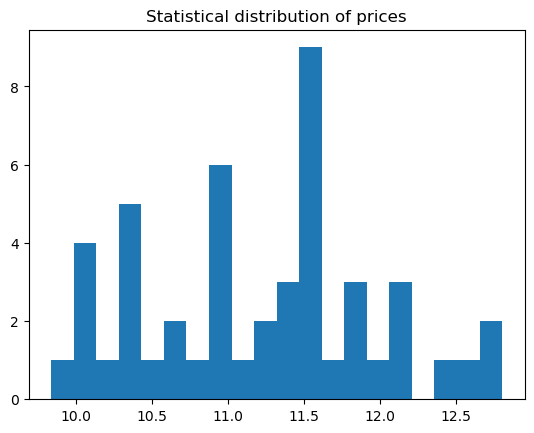

In [12]:
 # First let's take a look at the stock price distribution using matplotlib.pyplot
plt.hist(data_natural_gas['Prices'].values, bins=20)
plt.title('Statistical distribution of prices')
plt.show()

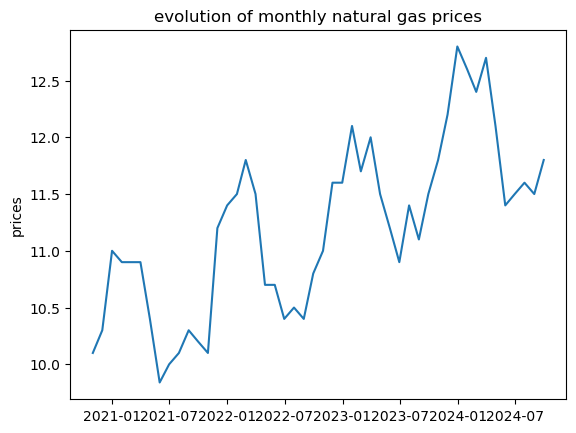

In [13]:
plt.plot(data_natural_gas['Prices'])
plt.ylabel('prices')
plt.title('evolution of monthly natural gas prices')
plt.show()

By analyzing the first figure we can see that the distribution of natural gas stock prices is asymetric and we have notable values with high occurence. By analyzing the second one, we can see that we have redundant patterns and consequently redundant values (which confirms the distribution). Furthermore, the trend is ascendant which shows that our data is non-stationnary. Visually, we assume that we have a yearly seasonality pattern. The trend can be explained by a strong demand over the years and also the geopolitical situation since Russia ( a leader on the gas market) has invaded Ukraine. The seasonality is due to the monotonic behaviour of a consumer over the years

## Third step : Model construction

Our model will be based on a time series analysis technique called SARIMA (Seasonal autoregressif integrated moving average). Our choice is justified by the decomposition below which gives more informative temporal caracteristic of time series in general. The idea is to decompose the time series into a trend + seasonal pattern + residual and observe each component.

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
caracteristics = seasonal_decompose(data_natural_gas['Prices'], model='additive', period=12)  

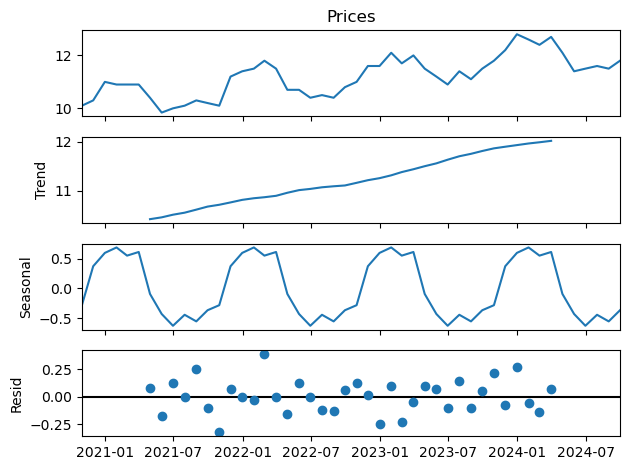

In [18]:
caracteristics.plot()
plt.tight_layout()
plt.show()

We can assume that we have a strong upward trend and a seasonal component that reapeat itself over our one year period. Before digging deeper into model construction let's check that residuals are effectively noise. To do so we will visualise the distribution of residuals.

Residual mean is : 0.00655092592592643
Residual variance is : 0.023354841269841317


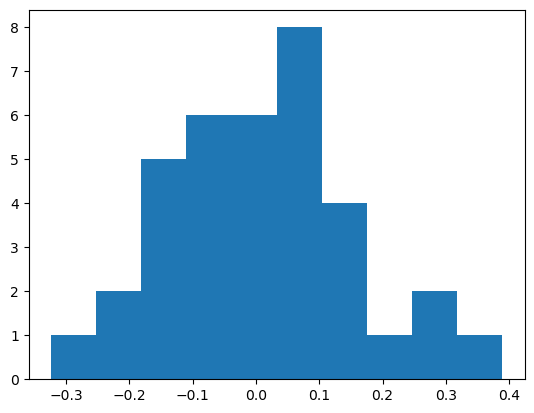

In [20]:
## Residuals distribution 
residuals=caracteristics.resid
plt.hist(residuals,bins=10)
print( 'Residual mean is :', residuals.mean())
print('Residual variance is :', residuals.var())

We can see that the residuals are effectively white noise following a quasi-gaussian distribution mean-centered and with low variance

## Dickey-Fuller test

We use the dickey-fuller test in order to determine wether a time series data is stationary or not. This helps finetune the model we will use later without getting an additional cross validation parameter.

In [24]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
   
    adf_result = adfuller(data, autolag='AIC')
    
    # We extract the results
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    
    # We print the ADF results
    print("ADF Test Results:")
    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {p_value}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"{key}: {value}")
    
    # We check for stationarity using p_value
    if p_value < 0.05:
        print("\nConclusion: The time series is stationary (reject the null hypothesis).")
    else:
        print("\nConclusion: The time series is non-stationary (fail to reject the null hypothesis).")
    
    return adf_result


In [25]:
## Let's use the function below to verify  data stationarity
adf_result= check_stationarity(data_natural_gas['Prices'])

ADF Test Results:
ADF Statistic: 0.21807686170000262
p-value: 0.9732574388448695
Critical Values:
1%: -3.6209175221605827
5%: -2.9435394610388332
10%: -2.6104002410518627

Conclusion: The time series is non-stationary (fail to reject the null hypothesis).


In [26]:
# Now let's determine the differentiation order we need. To do so we wille differentiate data until we get stationarity

## Let's try a fisrt differentiation

price_natural_gas_differentiated=data_natural_gas['Prices'].diff().dropna()

adf_result_1_diff=check_stationarity(price_natural_gas_differentiated)

ADF Test Results:
ADF Statistic: -6.844773557477352
p-value: 1.7541696852940142e-09
Critical Values:
1%: -3.6209175221605827
5%: -2.9435394610388332
10%: -2.6104002410518627

Conclusion: The time series is stationary (reject the null hypothesis).


That said our stationarity order is one. Let's construct our Sarima model then

In [28]:
## Splitting our data into train and test 
n=data_natural_gas.shape[0]
train_data=data_natural_gas[:n-12]
test_data=data_natural_gas[n-12:]

I could have used the train test split method and desactivating shuffle however I prefer a manual splitting that gives more sense to the sequential nature of the data.

In [30]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Here we construct a Sarima model which we finetune based on the Akaike criterion. The latter ensure that the model is not complex which is essential 
## To avoid overfitting specially since we have a small amout of samples. That said we will use a cross validation on (p,q) which are the AR and MA orders 
def sarima(train_data, d, seasonal_period, p_values, q_values):
    
    best_aic = np.inf 
    best_order = None
    best_model = None
    for p in p_values:
        for q in q_values:
            try:
                model = SARIMAX(train_data, order=(p, d, q), 
                                seasonal_order=(p, d, q, seasonal_period),
                                enforce_stationarity=False, enforce_invertibility=False)
                
                sarima_fitted = model.fit(disp=False)
                if sarima_fitted.aic < best_aic:
                    best_aic = sarima_fitted.aic
                    best_order = (p, d, q)
                    best_model = sarima_fitted
                    
            except Exception as e:
                print(f"Error fitting SARIMA model with (p, d, q)=({p}, {d}, {q}): {e}")
                continue 

    
    return best_model,best_order


In [31]:
best_model,best_order=sarima(train_data['Prices'], 1, 12, [0,1,2,3], [0,1,2,3])

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to

The warning we got tell us that we have few data to analyze in order to fit such as complex model. However using Akaike criterion the best ARMA model is (1,0) which is logical due to the lack of data. To verify the robustness of the regressors and moving averages let's analyze the model summary

In [33]:
# Let's take a look at the model's caracteristics 
print(best_order)

(1, 1, 0)


In [34]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.596
Date:                            Sat, 14 Sep 2024   AIC                              0.809
Time:                                    15:31:57   BIC                              1.717
Sample:                                10-31-2020   HQIC                            -0.187
                                     - 09-30-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9322      0.174     -5.351      0.000      -1.274      -0.591
ar.S.L12      -1.0539      0.176   

Let's observe that the coefficients arL1 and arSL12 are statistically significant ( p_value equals 0). Furthermore, the Ljung_box test suggests that the errors are correlated which is not a good sign. However the distribution is gaussian ( Jarque-Bera test) and the variance is small (check sigma2).Now let's test our model's prediction capabilities 

In [36]:
test_predictions=best_model.get_forecast(steps=len(test_data))

In [37]:
## Predicting values with the model
predicted_values=test_predictions.predicted_mean

In [38]:
## Observing the confidence intervals to observe the robustness of the model. A wide intervals indicates that the model is not so sure about the estimate
confidence_intervals=test_predictions.conf_int()

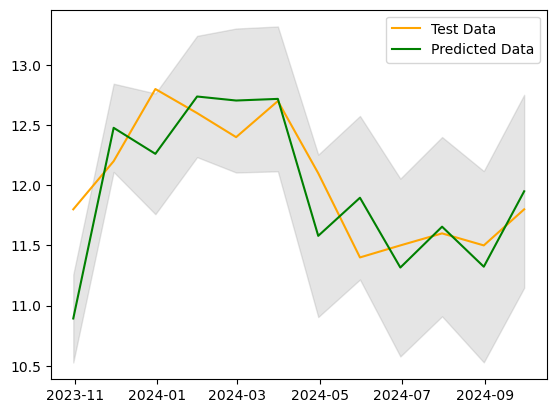

In [39]:
## Ploting the results and comparing with reality
plt.plot(test_data.index, test_data['Prices'], label='Test Data', color='orange')
plt.plot(test_data.index, predicted_values, label='Predicted Data', color='green')
plt.fill_between(test_data.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.2)
plt.legend()

Determining the just price of natural gas is impossible due to the market efficiency hypothesis. However the estimation given by our model is far from being trash. In fact, the predicted data and test data have the same mobile average . We can see that the shapes are similar. Furthermore our model correctly detects the price direction in many occasions. The confidence intervals have also the same shape as our test values. Furthermore, they get wide on trading ranges and tight when a trend is marked which confirms that the models detects upward and downward trends. Let's now predict natural gas price for a year to come

## Fourth step : Price prediction for the year to come

In [42]:
## Let's construct a Sarima model with the caracteristic we found , fit it on the hole data and try to predict the future

Sarima_model=SARIMAX(data_natural_gas['Prices'], order=(1, 1, 0), 
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False, enforce_invertibility=False)
fitted_model=Sarima_model.fit()

In [43]:
forecast_steps=12 # we forecast on 12 months
forecasts = fitted_model.get_forecast(steps=forecast_steps)
forecasts_values=forecasts.predicted_mean
confidence_intervals = forecasts.conf_int()

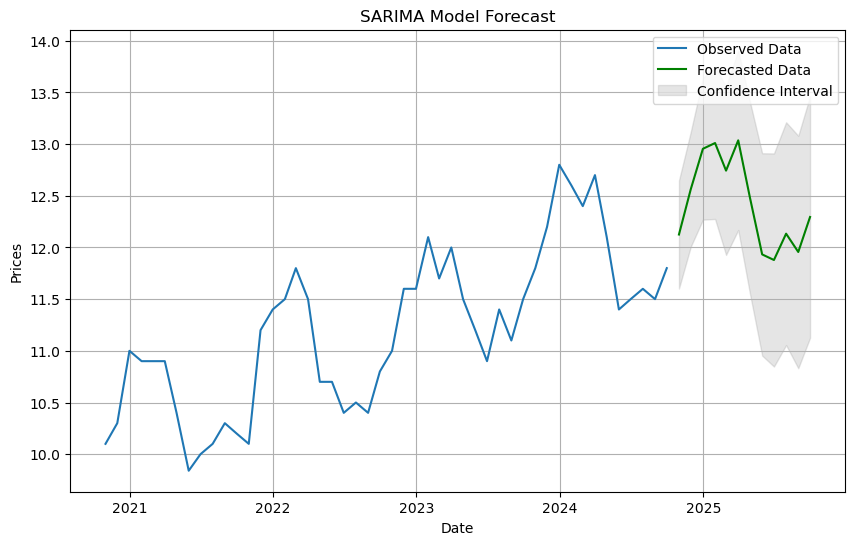

In [44]:
future_dates = pd.date_range(start=data_natural_gas.index[-1], periods=forecast_steps+1, freq='ME')[1:] 
forecast_df = pd.DataFrame({'Forecast': forecasts_values}, index=future_dates)

# Ploting the results

plt.figure(figsize=(10, 6))
plt.plot(data_natural_gas.index, data_natural_gas['Prices'], label='Observed Data')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Data', color='green')
plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')
plt.title("SARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.grid(True)
plt.show()

##  Fifth step: Reporting and Analysis

The model we used detects the seasonality and the price trend localizing with great fidelity the picks between the end of a year and the debut of another which maybe the consequence of holidays such as new year, summer vacancies but also winter period. 

## Conclusion and alternatives

The model we constructed gives respectable insights on the futur evolution of natural gas price. That being said we can do a lot more in terms of mathematical modelisation and machine learning techniques. With a good amount of samples ( daily basis for example) we can check other commodities which may be correlated with natural gas and also equities deriving from the energy industry. By combining historical data we can increase the explanatory power of our model and make more accurate predictions.